# Siddon Algorithm

This is what I plan to turn into a script.

I'm not sure if the graphical representation stuff will be added but it's nice to have for now.

*NOTE: perhaps I want to add X,Y,Z as constants at the top so that I can use them instead of magic numbers as indices* 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import interpolate

In [2]:
def alpha_func(plane,coor1,coor2):
    '''
    plane is assumed to be already calculated
    '''
    return (plane-coor1)/(coor2-coor1)

In [3]:
def plane_func(index,plane1,d):
    '''
    Parameters:
    ----------
    index :: integer
      index to evaluate at, index in (1,...,n)
    
    plane1 :: float 
      location of plane with index 1 
    
    d :: float 
      distance between planes
    
    Returns:
    -------
    plane_location :: float 
      the location of the plane of the specified index
    
    '''
    return plane1 + (index-1)*d

In [4]:
def voxel_length(alpha,index,d12):
    '''
    Parameters:
    ----------
    alpha :: list
      list of alpha values
    
    index :: integer
      index to evaluate at, index in (1,...,n)
    
    d12 :: float
      distance from point one to point two
    
    Returns:
    -------
    voxel_length :: float
      voxel intersection length
      
    '''
    
    return d12*(alpha[index]-alpha[index-1])

In [5]:
def voxel_indices(plane1s,coor1s,coor2s,distances,alpha,index):
    '''
    Parameters:
    ----------
    plane1s :: array
      coordinate plane (1) in form (x,y,z)
    
    coor1s :: array
      coordinate one in form (x,y,z)
    
    coor2s :: float
      coordinate two in form (x,y,z)
    
    distances :: float
      distance between two planes in form (x,y,z)
      
    alpha :: array
      ordered set of alpha values
    
    index :: integer
      i in 1,...,nfinal
    
    Returns:
    -------
    voxel_index :: integer
      voxel index for the specific coordinate 
    
    '''
    a_mid = alpha_mid(alpha,index)
    
    i = int(np.floor(1 + (coor1s[0] + a_mid*(coor2s[0]-coor1s[0])-plane1s[0])/distances[0]))
    j = int(np.floor(1 + (coor1s[1] + a_mid*(coor2s[1]-coor1s[1])-plane1s[1])/distances[1]))
    k = int(np.floor(1 + (coor1s[2] + a_mid*(coor2s[2]-coor1s[2])-plane1s[2])/distances[2]))
    
    return (i,j,k)

In [6]:
def alpha_mid(alpha,index):
    '''
    Parameters:
    ----------
    alpha :: array
      ordered set of alpha values
    
    index :: integer
      i in 1,...,nfinal
    
    Returns:
    -------
    alpha_mid :: float 
    
    '''
    return (alpha[index]+alpha[index-1])/2

In [7]:
def plot_grid_3D(size,bins,ifig=None,colour='b'):
    '''
    size :: tuple
      (x size, y size, z size) in centimeters
    
    bins :: tuple 
      (number of x bins, number of y bins, number of z bins)
    '''
    xlines = np.linspace(0,size[0],bins[0]+1)
    ylines = np.linspace(0,size[1],bins[1]+1)
    zlines = np.linspace(0,size[2],bins[2]+1)
    
    plt.close(ifig)
    fig = plt.figure(ifig)
    ax = plt.axes(projection='3d')
    
    for z in zlines:
        for x in xlines:
            ax.plot3D([x,x],[0,size[1]],z,colour)
        for y in ylines:
            ax.plot3D([0,size[0]],[y,y],z,colour)
    
    for y in ylines:
        for x in xlines:
            ax.plot3D([x,x],[y,y],[0,size[2]],colour)
    
    return ax,fig

In [8]:
def Siddon(num_planes,voxel_lengths,beam_coor,ini_planes,plot=False):
    '''
    Parameters:
    ----------
    num_planes :: tuple (3)
      (Nx,Ny,Nz) for a CT array of (Nx-1,Ny-1,Nz-1) voxels
    
    voxel_lengths :: tuple (3)
      distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
    
    beam_coor :: tuple (3,2)
      initial and final coordinates of the beam in the form ((x1,x2),(y1,y2),(z1,z2))
    
    ini_planes :: tuple (3)
      initial plane coordinates
    
    plot :: bool
      if True, plots a graphical representation of the problem
    
    Returns:
    -------
    voxel_info :: list 
      list of dictionaries each with keys 'd' (distance spent in voxel in cm), and 'indices' (the (x,y,z) indices of the voxel)
    
    '''
    coor_values = {'x':{},'y':{},'z':{}}

    coor_values['x']['N'] = num_planes[0]
    coor_values['y']['N'] = num_planes[1]
    coor_values['z']['N'] = num_planes[2]

    coor_values['x']['d'] = voxel_lengths[0]
    coor_values['y']['d'] = voxel_lengths[1]
    coor_values['z']['d'] = voxel_lengths[2]

    coor_values['x']['1,2'] = beam_coor[0]
    coor_values['y']['1,2'] = beam_coor[1]
    coor_values['z']['1,2'] = beam_coor[2]

    coor_values['x']['plane'] = [ini_planes[0]] # this ends up being min,max
    coor_values['y']['plane'] = [ini_planes[1]]
    coor_values['z']['plane'] = [ini_planes[2]]

    for key in coor_values.keys():
        coor_values[key]['plane'].append(plane_func(coor_values[key]['N'],coor_values[key]['plane'][0],coor_values[key]['d']))

    for key in coor_values.keys():
        if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] != 0:
            coor_values[key]['alpha_minmax'] = (alpha_func(coor_values[key]['plane'][0],coor_values[key]['1,2'][0],coor_values[key]['1,2'][1]),alpha_func(coor_values[key]['plane'][-1],coor_values[key]['1,2'][0],coor_values[key]['1,2'][1]))
        else:
            coor_values[key]['alpha_minmax'] = (0,1) # set to this so that it doesn't affect later business

    alpha_min = max(0,min(coor_values['x']['alpha_minmax']),min(coor_values['y']['alpha_minmax']),min(coor_values['z']['alpha_minmax']))
    alpha_max = min(1,max(coor_values['x']['alpha_minmax']),max(coor_values['y']['alpha_minmax']),max(coor_values['z']['alpha_minmax']))
    
    
    for key in coor_values.keys():
        if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] >= 0:
            indmin = coor_values[key]['N'] - (coor_values[key]['plane'][-1]-alpha_min*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
            indmax = 1 - (coor_values[key]['plane'][0]-alpha_max*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
            indmin = int(np.ceil(indmin))
            indmax = int(np.floor(indmax))
            coor_values[key]['indminmax'] = (indmin,indmax)
        else:
            indmin = coor_values[key]['N'] - (coor_values[key]['plane'][-1]-alpha_max*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
            indmax = 1 - (coor_values[key]['plane'][0]-alpha_min*(coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])-coor_values[key]['1,2'][0])/coor_values[key]['d']
            indmin = int(np.ceil(indmin))
            indmax = int(np.floor(indmax))
            coor_values[key]['indminmax'] = (indmin,indmax)
    
    alpha_coor_set = {}

    for key in coor_values.keys():
        if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] > 0:
            coor_values[key]['alpha_set'] = alpha_func(plane_func(np.array([n for n in range(coor_values[key]['indminmax'][0],coor_values[key]['indminmax'][1]+1)]),coor_values[key]['plane'][0],coor_values[key]['d']),coor_values[key]['1,2'][0],coor_values[key]['1,2'][1])
        elif coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] < 0:
            coor_values[key]['alpha_set'] = alpha_func(plane_func(np.array([n for n in range(coor_values[key]['indminmax'][1],coor_values[key]['indminmax'][0]-1,-1)]),coor_values[key]['plane'][0],coor_values[key]['d']),coor_values[key]['1,2'][0],coor_values[key]['1,2'][1])
        else:
            coor_values[key]['alpha_set'] = []    
    
    alpha = [alpha_min,alpha_max] + list(coor_values['x']['alpha_set']) + list(coor_values['y']['alpha_set']) + list(coor_values['z']['alpha_set'])
    alpha = np.sort(list(alpha))
    
    
    nfinal = 1
    d12 = 0
    for key in coor_values.keys():
        if coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0] != 0:
            nfinal += coor_values[key]['indminmax'][1] - coor_values[key]['indminmax'][0] + 1 
        d12 += (coor_values[key]['1,2'][1] - coor_values[key]['1,2'][0])**2
    d12 = np.sqrt(d12)
    
    voxel_info = []

    for i in range(1,nfinal+1):
        length = voxel_length(alpha,i,d12)
        indices = voxel_indices((coor_values['x']['plane'][0],coor_values['y']['plane'][0],coor_values['z']['plane'][0]),(coor_values['x']['1,2'][0],coor_values['y']['1,2'][0],coor_values['z']['1,2'][0]),(coor_values['x']['1,2'][1],coor_values['y']['1,2'][1],coor_values['z']['1,2'][1]),(coor_values['x']['d'],coor_values['y']['d'],coor_values['z']['d']),alpha,i)
        voxel_info.append({})
        voxel_info[i-1]['d'] = length
        voxel_info[i-1]['indices'] = indices
    
    if plot:
        ax,fig = plot_grid_3D((coor_values['x']['plane'][1]-coor_values['x']['plane'][0],coor_values['y']['plane'][1]-coor_values['y']['plane'][0],coor_values['z']['plane'][1]-coor_values['z']['plane'][0]),(coor_values['x']['N']-1,coor_values['y']['N']-1,coor_values['z']['N']-1),colour='g')
        ax.plot3D((coor_values['x']['1,2'][0],coor_values['x']['1,2'][1]),(coor_values['y']['1,2'][0],coor_values['y']['1,2'][1]),(coor_values['z']['1,2'][0],coor_values['z']['1,2'][1]),'r')
    
    return(voxel_info)
    

In [9]:
# filename variable is going to have to change as I move to not just calculating water 
def TERMA(num_planes,voxel_lengths,beam_coor,ini_planes,ini_energy,filename):
    '''
    Parameters:
    ----------
    num_planes :: tuple (3)
      (Nx,Ny,Nz) for a CT array of (Nx-1,Ny-1,Nz-1) voxels
    
    voxel_lengths :: tuple (3)
      distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
    
    beam_coor :: tuple (3,2)
      initial and final coordinates of the beam in the form ((x1,x2),(y1,y2),(z1,z2))
    
    ini_planes :: tuple (3)
      initial plane coordinates
    
    ini_energy :: float 
      the initial energy of the ray in MeV
    
    filename :: str 
      name of the file that contains values for energy absorption coefficients 
    
    Returns:
    -------
    voxel_info :: list 
      list of dictionaries each with keys 'd' (distance spent in voxel in cm), 'indices' (the (x,y,z) indices of the voxel),
      and 'fraction_lost' (the fraction of the initial number of photons lost in that voxel)
    '''
    coeff_array = np.loadtxt(filename,skiprows=2,dtype=float)

    e_a_coeffs = [] # energy absorption coefficients

    for row in coeff_array:
        e_a_coeffs.append([row[0],row[1]])
    e_a_coeffs = np.array(e_a_coeffs)
    
    # exponentially interpolate 
    mu_energy = interpolate.interp1d(e_a_coeffs.T[0],e_a_coeffs.T[1],kind='nearest',fill_value='extrapolate')
    mu = lambda energy, material: mu_energy(energy) # CHANGE THIS LATER TO A REAL FUNCTION
    
    voxel_info = Siddon(num_planes,voxel_lengths,beam_coor,ini_planes)
    
#     energy = ini_energy
    
#     for index in range(len(voxel_info)):
#         energy_lost = energy - energy*np.exp(-mu(energy,voxel_info[index]['indices'])*voxel_info[index]['d'])
#         voxel_info[index]['energy_lost'] = energy_lost
#         energy = energy - energy_lost
    fraction = 1
    for index in range(len(voxel_info)):
        fraction_lost = fraction - fraction*np.exp(-mu(ini_energy,voxel_info[index]['indices'])*voxel_info[index]['d'])
        voxel_info[index]['fraction_lost'] = fraction_lost
        fraction = fraction - fraction_lost
        
    
    return voxel_info 
    

In [ ]:
def Superposition(kernel_array,kernel_size,num_planes,voxel_lengths,voxel_info):
    '''
    Parameters:
    ----------
    kernel_array :: numpy array 
      array with normalized kernel: should be an odd number of voxels, interacting in the center
    
    kernel_size :: tuple (3)
      (x,y,z) dimensions of the kernel in cm 
    
    num_planes :: tuple (3)
      (Nx,Ny,Nz) for a CT array of (Nx-1,Ny-1,Nz-1) voxels
    
    voxel_lengths :: tuple (3)
      distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
    
    voxel_info :: list 
      list of dictionaries each with keys 'd' (distance spent in voxel in cm), 'indices' (the (x,y,z) indices of the voxel),
      'fraction_lost' (the fraction of the initial number of photons lost in that voxel), and 'TERMA' (the TERMA) 
    
    Returns:
    -------
    energy_deposit :: list 
      list of dictionaries each with keys 'indices' (the (x,y,z) indices of the voxel) and 'energy' (the energy deposited in 
      each voxel i.e. the dose) 
    
    '''
    Nx = num_planes[0]
    Ny = num_planes[1]
    Nz = num_planes[2]
    
    dx = voxel_lengths[0]
    dy = voxel_lengths[1]
    dz = voxel_lengths[2]
    
    kernel_info = {}
    kernel_info['x'] = {}
    kernel_info['y'] = {}
    kernel_info['z'] = {}

    kernel_info['x']['bins'] = len(kernel_array)
    kernel_info['y']['bins'] = len(kernel_array[0])
    kernel_info['z']['bins'] = len(kernel_array[0][0])

    kernel_info['x']['size'] = kernel_size[0]
    kernel_info['y']['size'] = kernel_size[1]
    kernel_info['z']['size'] = kernel_size[2]

    kernel_info['x']['voxel_size'] = kernel_info['x']['size']/kernel_info['x']['bins']
    kernel_info['y']['voxel_size'] = kernel_info['y']['size']/kernel_info['y']['bins']
    kernel_info['z']['voxel_size'] = kernel_info['z']['size']/kernel_info['z']['bins']
    
    
    # this x,y,z are just for kernel_func
    x = np.linspace(0,kernel_info['x']['bins']-1,kernel_info['x']['bins'])
    y = np.linspace(0,kernel_info['y']['bins']-1,kernel_info['y']['bins'])
    z = np.linspace(0,kernel_info['z']['bins']-1,kernel_info['z']['bins'])
    
    kernel_func = interpolate.RegularGridInterpolator((x,y,z),kernel_array,bounds_error=False,fill_value=0)
    
    
    center_coor = (int(np.floor(len(kernel_array)/2)),int(np.floor(len(kernel_array[0])/2)),int(np.floor(len(kernel_array[0][0])/2)))
    
    energy_deposit = []
    
    # making array for labelling voxels 
    x_voxels = np.linspace(0,Nx-2,Nx-1)
    y_voxels = np.linspace(0,Ny-2,Ny-1)
    z_voxels = np.linspace(0,Nz-2,Nz-1)
    
    voxel_array = []
    for x in x_voxels:
        for y in y_voxels:
            for z in z_voxels:
                voxel_array.append(np.array([x,y,z]))
    voxel_array = np.array(voxel_array)
    
    voxel_diff = ['','','']
    for voxel_ind in range(len(voxel_info)):
        for n in range(len(voxel_array)):
            voxel_diff[0] = voxel_array[n][0] - voxel_info[voxel_ind]['indices'][0]-1
            voxel_diff[1] = voxel_array[n][1] - voxel_info[voxel_ind]['indices'][1]-1
            voxel_diff[2] = voxel_array[n][2] - voxel_info[voxel_ind]['indices'][2]-1
            
            if voxel_ind == 0:
                energy_deposit.append({})
                energy_deposit[n]['indices'] = (voxel_array[n][0]+1,voxel_array[n][1]+1,voxel_array[n][2]+1)
            
            kernel_value = kernel_func((center_coor[0]+voxel_diff[0]*dx/kernel_info['x']['voxel_size'],center_coor[1]+voxel_diff[1]*dy/kernel_info['y']['voxel_size'],center_coor[2]+voxel_diff[1]*dz/kernel_info['z']['voxel_size']))
            # still need to figure out TERMA properly
            energy_deposit[n]['energy'] += kernel_value * voxel_info[voxel_ind]['TERMA']
            
    return energy_deposit
    

In [12]:
def Dose_Calculator(num_planes,voxel_lengths,beam_coor,ini_planes,ini_energy,filename,kernelname,kernel_size):
    '''
    Parameters:
    ----------
    num_planes :: tuple (3)
      (Nx,Ny,Nz) for a CT array of (Nx-1,Ny-1,Nz-1) voxels
    
    voxel_lengths :: tuple (3)
      distances between the x,y,z planes (also the lengths of the sides of the voxels) in cm
    
    beam_coor :: tuple (3,2)
      initial and final coordinates of the beam in the form ((x1,x2),(y1,y2),(z1,z2))
    
    ini_planes :: tuple (3)
      initial plane coordinates
    
    ini_energy :: float 
      the initial energy of the ray in MeV
    
    filename :: str 
      name of the file that contains values for energy absorption coefficients 
    
    kernelname :: str
      name or pathway of file from TOPAS that contains kernel information
    
    kernel_size :: tuple (3)
      (x,y,z) dimensions of the kernel in cm 
    
    Returns:
    -------
    energy_deposit :: list 
      list of dictionaries each with keys 'indices' (the (x,y,z) indices of the voxel) and 'energy' (the energy deposited in 
      each voxel i.e. the dose) 
    
    '''
    
    voxel_info = TERMA(num_planes,voxel_lengths,beam_coor,ini_planes,ini_energy,filename)
    
    kernel_array_raw = BinnedResult(kernelname).data['Sum'] # non-normalized array
    kernel_array = kernel_array_raw/np.sum(kernel_array_raw) # normalized array 
        
    return Superposition(kernel_array,kernel_size,num_planes,voxel_lengths,voxel_info)

### Anything below here does not belong in script 

[{'d': 0.0, 'indices': (4, 2, 4)},
 {'d': 0.16709129580497856, 'indices': (4, 2, 3)},
 {'d': 0.23392781412696972, 'indices': (4, 1, 3)},
 {'d': 0.601528664897923, 'indices': (3, 1, 3)},
 {'d': 0.10025477748298717, 'indices': (3, 1, 2)},
 {'d': 0.7017834423809102, 'indices': (2, 1, 2)},
 {'d': 0.20050955496597395, 'indices': (1, 1, 2)},
 {'d': 0.5012738874149358, 'indices': (1, 1, 1)},
 {'d': 0.0, 'indices': (1, 1, 1)},
 {'d': 0.0, 'indices': (1, 1, 1)}]

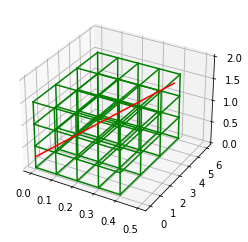

In [11]:
# for a CT array of (Nx-1,Ny-1,Nz-1) voxels
Nx = 5 
Ny = 4
Nz = 4

# distances between the x,y,z planes (also the lengths of the sides of the voxels)
dx = 0.1
dy = 2
dz = 0.5

# initial and final coordinates of the beam
x1,x2 = (0.5,0)
y1,y2 = (3,0)
z1,z2 = (2,0.25)

# initial plane coordinates
xplane1 = 0
yplane1 = 0
zplane1 = 0

# beam info and filename
ini_energy = 0.120 # in MeV
filename = 'energy_absorption_coeff.txt'

Siddon((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),plot=True)
# TERMA((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),ini_energy,filename)

[{'d': 0.0, 'indices': (3, 2, 2)},
 {'d': 2.5000000000000004, 'indices': (2, 2, 2)},
 {'d': 2.5, 'indices': (1, 2, 2)},
 {'d': 0.0, 'indices': (1, 2, 2)}]

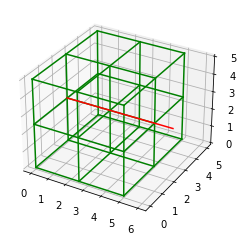

In [12]:
# for a CT array of (Nx-1,Ny-1,Nz-1) voxels
Nx = 3
Ny = 3
Nz = 3

# distances between the x,y,z planes (also the lengths of the sides of the voxels)
dx = 2.5
dy = 2.5
dz = 2.5

# initial and final coordinates of the beam
x1,x2 = (6,0)
y1,y2 = (2.5,2.5)
z1,z2 = (2.5,2.5)

# initial plane coordinates
xplane1 = 0
yplane1 = 0
zplane1 = 0

Siddon((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),plot=True)

In [14]:
# for a CT array of (Nx-1,Ny-1,Nz-1) voxels
Nx = 513
Ny = 513
Nz = 513

# distances between the x,y,z planes (also the lengths of the sides of the voxels)
dx = 0.1
dy = 0.1
dz = 0.1

# initial and final coordinates of the beam
x1,x2 = (8,0)
y1,y2 = (300,2)
z1,z2 = (4,-6)

# initial plane coordinates
xplane1 = -5
yplane1 = 0
zplane1 = -8

# beam info and filename
ini_energy = 0.120 # in MeV
filename = 'energy_absorption_coeff.txt'

# Siddon((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1))
TERMA((Nx,Ny,Nz),(dx,dy,dz),((x1,x2),(y1,y2),(z1,z2)),(xplane1,yplane1,zplane1),ini_energy,filename)


[{'d': 0.10009229559056618,
  'indices': (64, 512, 37),
  'fraction_lost': 0.016940621096616426},
 {'d': 0.10009229559056618,
  'indices': (64, 511, 37),
  'fraction_lost': 0.016653636453477283},
 {'d': 0.10009229559059929,
  'indices': (64, 510, 37),
  'fraction_lost': 0.016371513508443458},
 {'d': 0.10009229559056618,
  'indices': (64, 509, 37),
  'fraction_lost': 0.016094169901313515},
 {'d': 0.10009229559059929,
  'indices': (64, 508, 37),
  'fraction_lost': 0.015821524667155917},
 {'d': 0.10009229559059929,
  'indices': (64, 507, 37),
  'fraction_lost': 0.01555349821259877},
 {'d': 0.10009229559056618,
  'indices': (64, 506, 37),
  'fraction_lost': 0.015290012292647148},
 {'d': 0.07506922169291635,
  'indices': (64, 505, 37),
  'fraction_lost': 0.011297284583115852},
 {'d': 0.025023073897682938,
  'indices': (63, 505, 37),
  'fraction_lost': 0.0037337054047238416},
 {'d': 0.10009229559056618,
  'indices': (63, 504, 37),
  'fraction_lost': 0.014776355681743736},
 {'d': 0.1000922955